In [1]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns 
import statsmodels.stats.proportion as proportion
from scipy.stats import ttest_ind,mannwhitneyu,shapiro,norm
from statsmodels.stats.weightstats import ztest
from tqdm import tqdm
import timeit
from scipy import stats
import math
from datetime import date, datetime, timedelta
import time
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker
import warnings
warnings.filterwarnings("ignore")


sys.path.append('/Users/kemran/Desktop/work_files/python_files') 
from credential import postgres_secret,clickhouse_dwh_secret

def get_engine(user):
    if user == postgres_secret['user']:
        db_name = postgres_secret['db_name']
        password = postgres_secret['password']
        host = postgres_secret['host']
        engine = create_engine(f'postgresql://{user}:{password}@{host}:6432/{db_name}')
    elif user == clickhouse_dwh_secret['user']:
            db_name = clickhouse_dwh_secret['db_name'] 
            password = clickhouse_dwh_secret['password']
            host = clickhouse_dwh_secret['host']
            engine = create_engine(f'clickhouse://{user}:{password}@{host}:8123/{db_name}')
    return engine
    

    
def execute(SQL, user):
    start_time = time.time()  # запоминаем время начала выполнения функции
    engine = get_engine(user)
    Session = sessionmaker(bind=engine)  # sessions factory ()
    with Session() as session: # open session
        result = session.execute(text(SQL))
        df = pd.DataFrame(result.fetchall(), columns=result.keys())
        
    end_time = time.time()  # запоминаем время окончания выполнения функции
    execution_time = round(end_time - start_time,4) # вычисляем время выполнения   
    
    print(f"Время выполнения функции: {execution_time} секунд")
    print()
    return df

In [17]:
query = '''
SELECT 
date,
profile_id,
user_id,
event_name,
client_type,
app_version,
device_type,
JSONExtractString(JSONExtractString(payload,'flags'),'all_platform_test_AA') AS flags
FROM datamarts.clean_event
WHERE date>='2025-01-15' AND user_id IS NOT NULL AND client_type!='backend'
GROUP BY 1,2,3,4,5,6,7,8
'''

df = execute(query,user='kmekhtiev')

Время выполнения функции: 18.4736 секунд



In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378166 entries, 0 to 378165
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   date         378166 non-null  object
 1   profile_id   374875 non-null  object
 2   user_id      378166 non-null  object
 3   event_name   378166 non-null  object
 4   client_type  378166 non-null  object
 5   app_version  369809 non-null  object
 6   device_type  369838 non-null  object
 7   flags        378166 non-null  object
dtypes: object(8)
memory usage: 23.1+ MB


In [21]:
df['date'] = df['date'].astype('datetime64[ns]')
df['date'] = df['date'].dt.date
df['flags_type'] = df['flags'].apply(lambda x : 'wo_flag' if x=='' else 'w_flag')
df_agg = df.groupby(['date','flags'])['user_id'].nunique().reset_index()
df_agg

,date,flags,user_id
0,2025-01-15,,2103
1,2025-01-15,all_platform_test_AA_A,904
2,2025-01-15,all_platform_test_AA_B,961
3,2025-01-15,all_platform_test_AA_C,953
4,2025-01-16,,1417
5,2025-01-16,all_platform_test_AA_A,1474
6,2025-01-16,all_platform_test_AA_B,1471
7,2025-01-16,all_platform_test_AA_C,1482
8,2025-01-17,,1354
9,2025-01-17,all_platform_test_AA_A,1388


# Распределение по группам (кто получил)

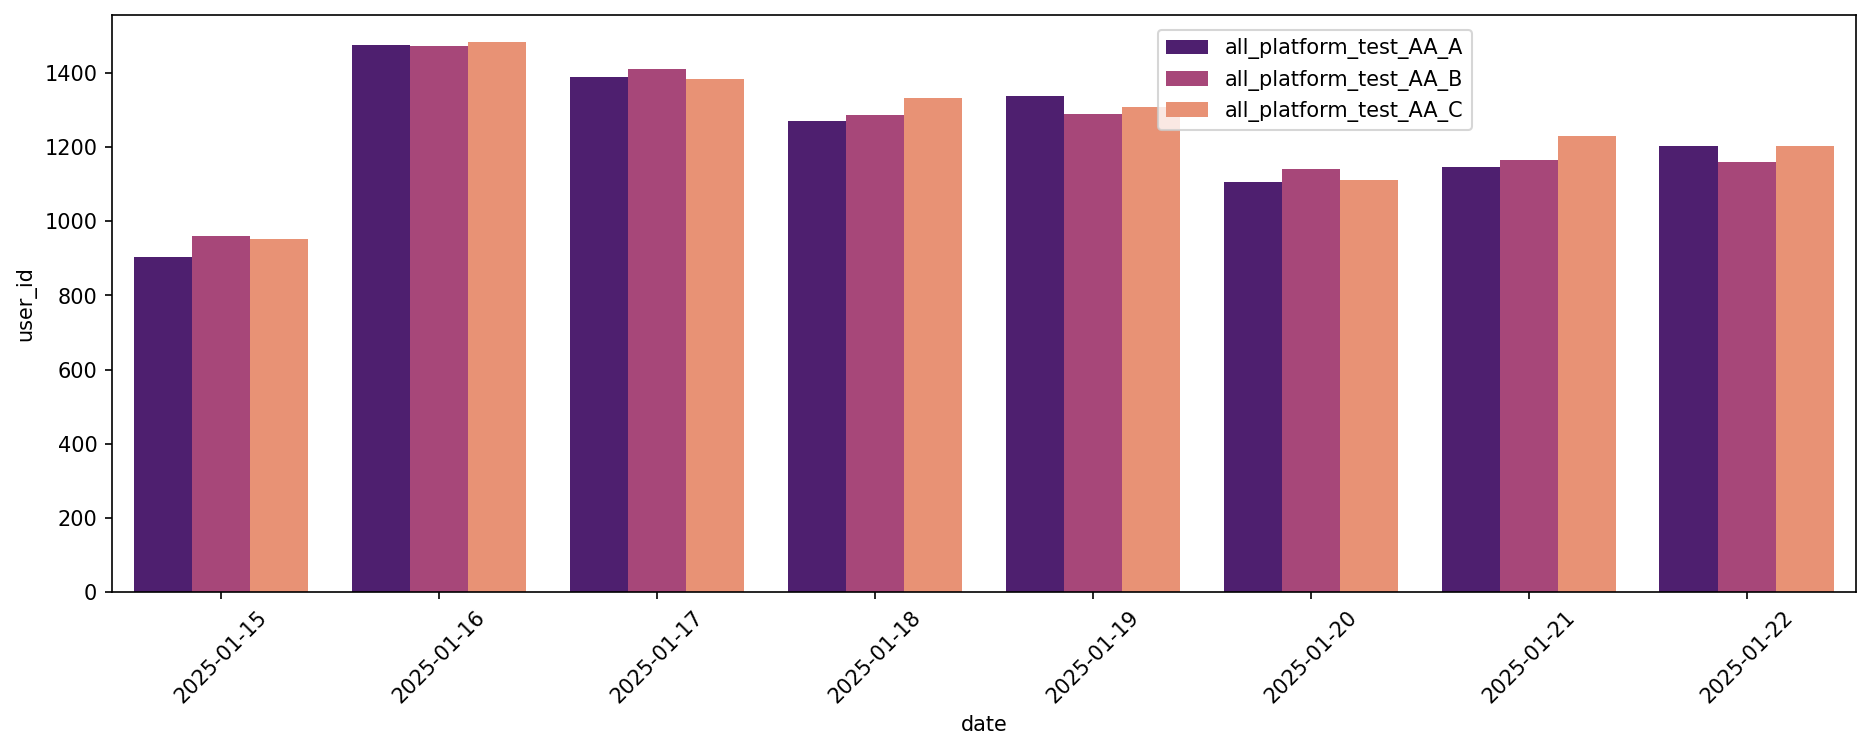

In [24]:
plt.figure(figsize=(15,5),dpi=150)

sns.barplot(data=df_agg[df_agg['flags']!=''],x='date',y='user_id',hue='flags',palette='magma')
plt.xticks(rotation=45)
plt.legend(loc=(0.6,0.8))

plt.show()

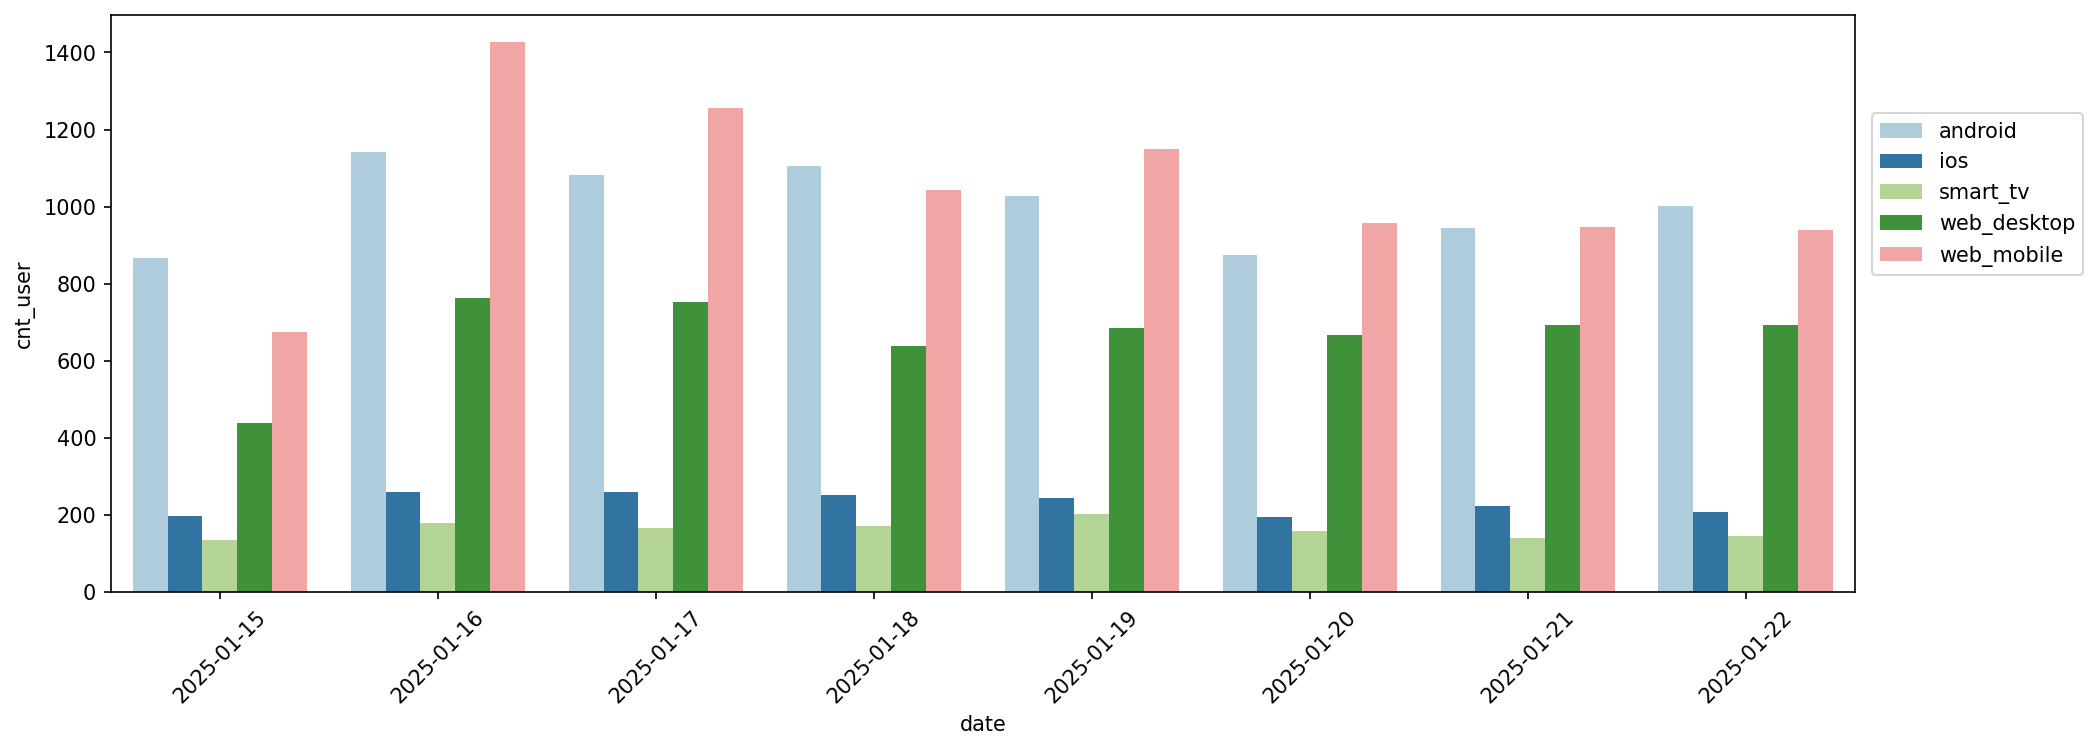

In [32]:
plt.figure(figsize=(15,5),dpi=150)

#sns.barplot(data=df[(df['flags']!='') & (df['client_type'].isin(['ios','web_mobile','web_desktop','smart_tv']))].groupby(['date','client_type'])['user_id'].nunique().reset_index(),x='date',y='user_id',hue='client_type',palette='Paired')
sns.barplot(data=df[(df['flags']!='')].groupby(['date','client_type'])['user_id'].nunique().reset_index(),x='date',y='user_id',hue='client_type',palette='Paired')
plt.xticks(rotation=45)
#plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: pd.to_datetime(x).strftime('%Y-%m-%d')))  
plt.legend(loc=(1.01,0.55))
plt.ylabel('cnt_user')

plt.show()

# Кто не получает группы

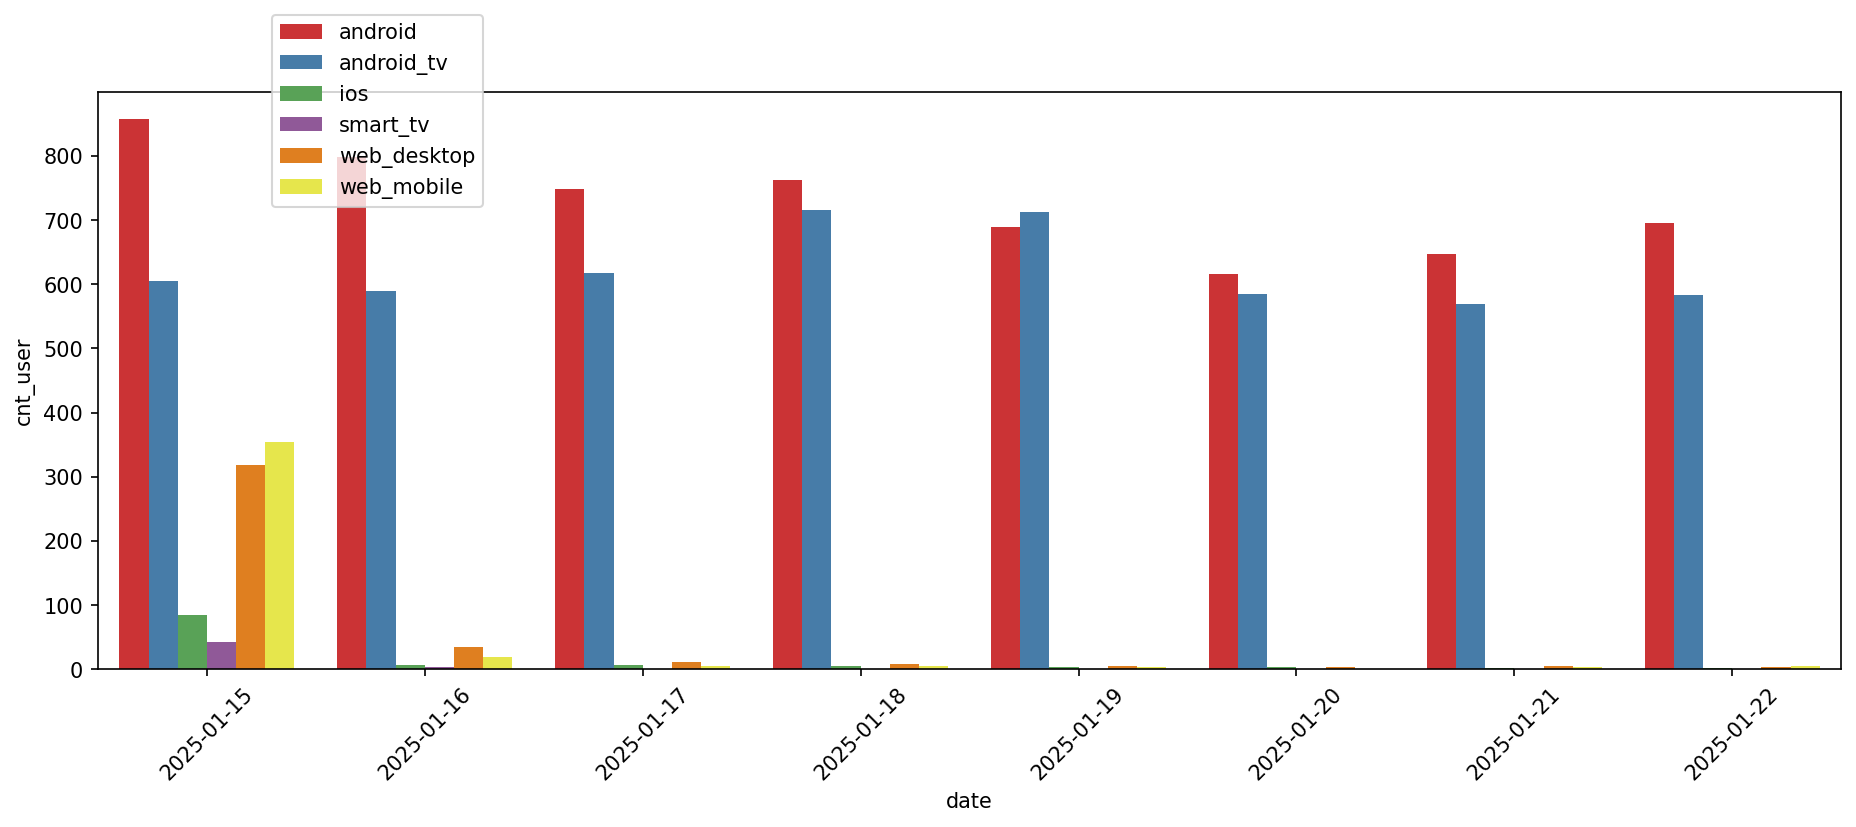

In [35]:
plt.figure(figsize=(15,5),dpi=150)

sns.barplot(data=df[(df['flags']=='')].groupby(['date','client_type'])['user_id'].nunique().reset_index(),x='date',y='user_id',hue='client_type',palette='Set1')
plt.xticks(rotation=45)
#plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: pd.to_datetime(x).strftime('%Y-%m-%d')))  
plt.legend(loc=(0.1,0.8))
plt.ylabel('cnt_user')

plt.show()

In [43]:
# t = df[(df['client_type'].isin(['ios','web_mobile','web_desktop']))]\
#                 .groupby(['client_type','app_version','flags_type'])['user_id']\
#                 .nunique()\
#                 .reset_index()

t = df[(df['client_type'].isin(['android']))]\
                .groupby(['client_type','app_version','flags_type'])['user_id']\
                .nunique()\
                .reset_index()

pivot = pd.pivot(data = t, index=['client_type','app_version'], columns='flags_type',values='user_id').fillna(0)
pivot['total'] = pivot['w_flag'] + pivot['wo_flag']
pivot['w_frac'] = round(pivot['w_flag']/pivot['total'],2)
pivot

flags_type                w_flag  wo_flag   total  w_frac
client_type app_version                                  
android     2.38             0.0      1.0     1.0    0.00
            2.41             0.0      8.0     8.0    0.00
            2.42             0.0      2.0     2.0    0.00
            2.44             0.0      7.0     7.0    0.00
            2.45             0.0      6.0     6.0    0.00
            2.48             0.0     36.0    36.0    0.00
            2.49             0.0      8.0     8.0    0.00
            2.50             0.0      1.0     1.0    0.00
            2.51             0.0      3.0     3.0    0.00
            2.52             0.0     71.0    71.0    0.00
            2.53-prod       13.0      0.0    13.0    1.00
            2.54-prod       17.0      4.0    21.0    0.81
            2.55-prod      129.0     11.0   140.0    0.92
            2.56-prod       19.0      8.0    27.0    0.70
            2.57-prod      140.0     24.0   164.0    0.85
            2.58-preprod     3.0      0.0     3.0    1.00
            2.58-prod     4905.0    907.0  5812.0    0.84
            2.58-prod_am    59.0      4.0    63.0    0.94

# Пользователи, которые попали в несколько групп

In [49]:
df_w_duplic = df[(df['client_type'].isin(['ios','web_mobile','web_desktop','android','smart_tv']))\
        & (df['flags_type']=='w_flag')]\
        [['user_id','flags','flags_type','client_type','app_version']]\
        .drop_duplicates()

df_w_duplic=df_w_duplic[['user_id','client_type','app_version']].value_counts().reset_index()

df_only_duplic = df_w_duplic[df_w_duplic['count']>1]

df_w_duplic[df_w_duplic['count']>1].groupby('client_type')['count'].sum()

client_type
android        8483
ios             825
smart_tv        512
web_desktop     437
web_mobile      825
Name: count, dtype: int64

In [37]:
df_w_duplic

,user_id,client_type,app_version,count
0,bd97fde0-fc1e-4341-9ecf-57912504c1c5,web_mobile,4.12.1-prod,2
1,91d55af0-8476-4fe1-bd02-e895a00a2f7d,web_desktop,4.12.1-prod,2
2,cbe3d71d-c808-44b4-b4ff-574665b083fe,web_mobile,4.12.1-prod,2
3,cbe46c5e-7123-47b2-ad94-612bd9135481,web_mobile,4.12.1-prod,2
4,cbed7312-612d-4fd5-8235-9d7defd3ef32,web_desktop,4.12.1-prod,2
...,...,...,...,...
14205,562cd809-b9f3-44ab-bff5-cad4670b0aa6,web_desktop,4.12.1-prod,1
14206,562d16a1-8692-4f5f-8b48-c42887f79686,web_desktop,4.12.1-prod,1
14207,562f81d5-0be8-473b-a1eb-184c4418df37,web_mobile,4.12.0-prod,1
14208,563387a9-ba46-4db5-aa84-5c0c0a7db365,web_mobile,4.12.1-prod,1


In [39]:
df[df['user_id']=='bdbaa36d-b129-4f07-9966-9fdb773128b0']['flags'].value_counts()

flags
           149
group_a     20
Name: count, dtype: int64

In [41]:
df_w_duplic2 = df[(df['client_type'].isin(['ios','web_mobile','web_desktop','flags','device_type']))\
        & (df['flags_type']=='w_flag')]\
        [['user_id','flags','flags_type','client_type','app_version','device_type']]\
        .drop_duplicates()

In [43]:
df_w_duplic2

,user_id,flags,flags_type,client_type,app_version,device_type
3,de4eca9a-3e1e-4685-91a3-32ed42143f70,group_b,w_flag,web_mobile,4.12.1-prod,Web / Desktop APP / Unknown
5,e09bb21b-655d-4bcf-857e-5e494bfdfceb,group_a,w_flag,web_desktop,4.12.1-prod,Web / Desktop APP / Unknown
6,58ffe721-aab8-43bb-b8d5-9743aea066a6,group_b,w_flag,web_mobile,4.12.1-prod,Web / Desktop APP / Unknown
11,a62db2a7-6825-47b9-a2b9-b91c96b260f8,group_b,w_flag,web_mobile,4.12.1-prod,Web / Desktop APP / Unknown
20,e7260d20-57b3-4d4f-8f32-8e2ed6c5909a,group_a,w_flag,web_mobile,4.12.1-prod,Web / Desktop APP / Unknown
...,...,...,...,...,...,...
467803,03562d15-b502-4577-8579-ac121f5833de,group_a,w_flag,web_mobile,4.12.1-prod,Web / Desktop APP / Unknown
468246,738935c5-caf1-4d61-9644-7faebe290e0e,group_a,w_flag,web_desktop,4.12.1-prod,Web / Desktop APP / Unknown
468272,9bde824c-e881-4ad2-9cdd-19ab38517ae5,group_a,w_flag,web_desktop,4.12.1-prod,Web / Desktop APP / Unknown
468526,6bbacf90-2241-4de8-a251-b2383d824ca0,group_a,w_flag,web_mobile,4.12.1-prod,Web / Desktop APP / Unknown


In [45]:
df_w_duplic2[df_w_duplic2['user_id']=='bdbaa36d-b129-4f07-9966-9fdb773128b0']

,user_id,flags,flags_type,client_type,app_version,device_type
2480,bdbaa36d-b129-4f07-9966-9fdb773128b0,group_a,w_flag,web_desktop,4.12.1-prod,Web / Desktop APP / Unknown


In [47]:
df_merge = pd.merge(df_w_duplic2,df_only_duplic['user_id'],how='left',on='user_id',indicator='user_type')

df_merge_wo_duplic = df_merge[df_merge['user_type']=='left_only']
df_merge_wo_duplic

,user_id,flags,flags_type,client_type,app_version,device_type,user_type
0,de4eca9a-3e1e-4685-91a3-32ed42143f70,group_b,w_flag,web_mobile,4.12.1-prod,Web / Desktop APP / Unknown,left_only
1,e09bb21b-655d-4bcf-857e-5e494bfdfceb,group_a,w_flag,web_desktop,4.12.1-prod,Web / Desktop APP / Unknown,left_only
3,a62db2a7-6825-47b9-a2b9-b91c96b260f8,group_b,w_flag,web_mobile,4.12.1-prod,Web / Desktop APP / Unknown,left_only
4,e7260d20-57b3-4d4f-8f32-8e2ed6c5909a,group_a,w_flag,web_mobile,4.12.1-prod,Web / Desktop APP / Unknown,left_only
5,322794f3-f2a3-481f-92c0-951037a3209b,group_a,w_flag,web_mobile,4.12.1-prod,Web / Desktop APP / Unknown,left_only
...,...,...,...,...,...,...,...
14811,0a2e2108-81c4-45d9-a104-a89e39e7d2e3,group_a,w_flag,web_desktop,4.12.1-prod,Web / Desktop APP / Unknown,left_only
14813,1c6512e2-984c-4ebf-9c37-1d543f895560,group_a,w_flag,web_mobile,4.12.1-prod,Web / Desktop APP / Unknown,left_only
14815,03562d15-b502-4577-8579-ac121f5833de,group_a,w_flag,web_mobile,4.12.1-prod,Web / Desktop APP / Unknown,left_only
14817,9bde824c-e881-4ad2-9cdd-19ab38517ae5,group_a,w_flag,web_desktop,4.12.1-prod,Web / Desktop APP / Unknown,left_only


In [49]:
df_merge_wo_duplic[df_merge_wo_duplic['user_id']=='bdbaa36d-b129-4f07-9966-9fdb773128b0']

,user_id,flags,flags_type,client_type,app_version,device_type,user_type
842,bdbaa36d-b129-4f07-9966-9fdb773128b0,group_a,w_flag,web_desktop,4.12.1-prod,Web / Desktop APP / Unknown,left_only


# Распределения

In [52]:
def plot_segments_distribution(df, segment_columns, test_factor):
    for i in segment_columns:
        aggregated_data = df.groupby(by = [test_factor,i])['user_id'].count().reset_index()
        sns.catplot(x = i, y = 'user_id', hue = test_factor, data = aggregated_data.sort_values(by='user_id', ascending=False).iloc[:40], kind = "bar", height = 4, aspect = 1.5)
        plt.xticks(rotation=100)
        plt.title(i)

In [54]:
df_merge_wo_duplic['client_type'].unique()

array(['web_mobile', 'web_desktop'], dtype=object)

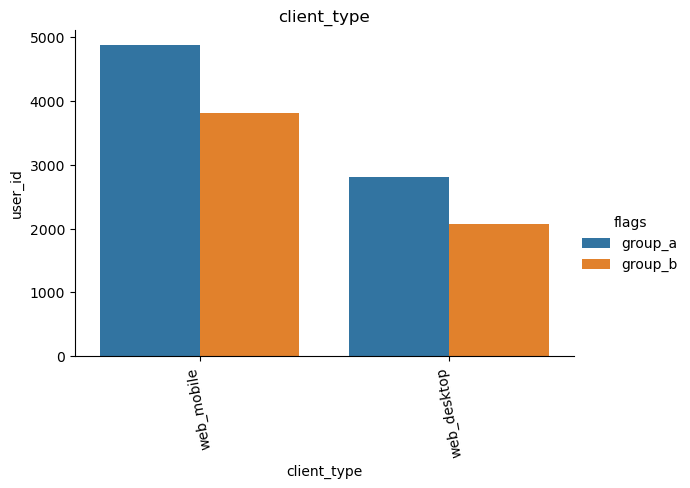

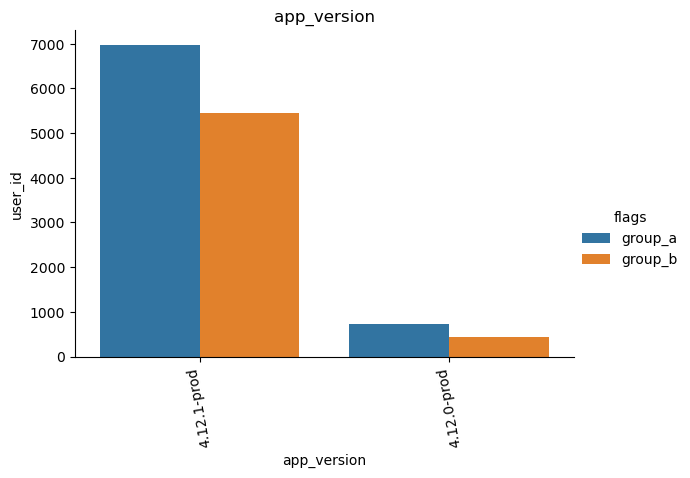

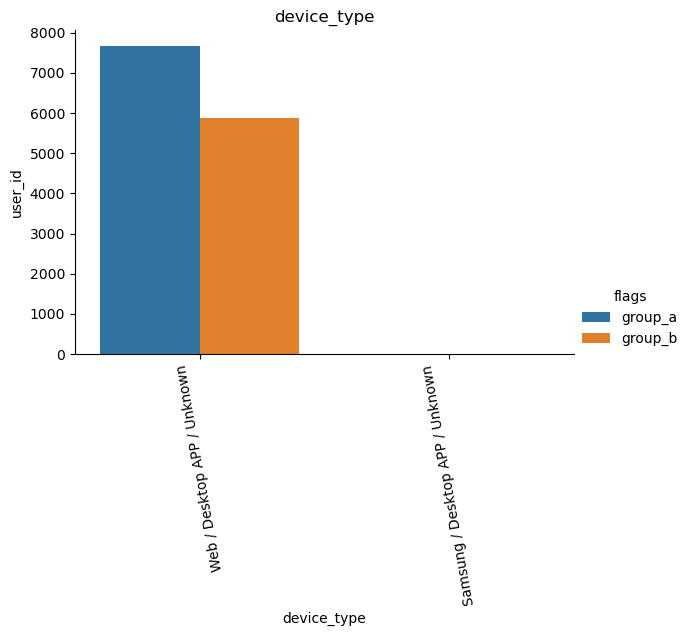

In [56]:
plot_segments_distribution(df_merge_wo_duplic,['client_type','app_version','device_type'],'flags')

# Тест на независимость 

In [59]:
## Функция для хи-квадра по определению независимости между выборками
def chi_independence(df, control, test_1, segment_name, part=None):
        '''H0: distributions are independent, H1: distributions are dependent '''
        for segment in segment_name:
                control1 = df[df['flags'] == control][segment].value_counts()
                test1 = df[df['flags'] == test_1][segment].value_counts()
                #test2 = df[df['flags'] == test_2][segment].value_counts()
                concat = pd.concat([control1,test1], axis=1)
                concat.columns = ['control1','test1']
                if part:
                    print(concat.iloc[:part])
                    stat, p_value, dof, expected = stats.chi2_contingency(concat.iloc[:part])
                else:
                    stat, p_value, dof, expected = stats.chi2_contingency(concat)

                if p_value <= 0.01:
                        print (f' {segment}- p-value: {p_value:.4f}, statistic: {stat:.4f}, dof: {dof}, dependent (reject H0)\n')
                else:
                        print (f' {segment} - p-value: {p_value:.4f}, statistic: {stat:.4f}, dof: {dof}, independent (fail to reject H0)\n')


In [61]:
chi_independence(df_merge_wo_duplic,
                 'group_a',
                 'group_b',
                 ['client_type','app_version','device_type'],
                10)

             control1  test1
client_type                 
web_mobile       4871   3814
web_desktop      2814   2073
 client_type - p-value: 0.0949, statistic: 2.7895, dof: 1, independent (fail to reject H0)

             control1  test1
app_version                 
4.12.1-prod      6962   5451
4.12.0-prod       723    436
 app_version- p-value: 0.0000, statistic: 16.8471, dof: 1, dependent (reject H0)

                                 control1  test1
device_type                                     
Web / Desktop APP / Unknown          7678   5880
Samsung / Desktop APP / Unknown         7      7
 device_type - p-value: 0.8176, statistic: 0.0532, dof: 1, independent (fail to reject H0)



# Тест на однородность 

In [64]:
def chi_homogeneity(df, control, test_1, segment_name,number_of_groups, part=None):
    '''H0: distributions are homogeneous, H1: distributions are not homogeneous '''
    for segment in segment_name:
            control1 = df[df['flags'] == control][segment].value_counts()
            test1 = df[df['flags'] == test_1][segment].value_counts()
            #test2 = df[df['flags'] == test_2][segment].value_counts()
            concat = pd.concat([control1,test1], axis=1)
            concat.columns = ['control_1','test_1']
            concat['expected']=concat.sum(axis=1).apply(lambda x: math.ceil(x / number_of_groups))
            print(concat.iloc[:part])
            for i in concat.columns[:-1]:
                    # рассчитываем статистику
                    k = len(concat[i].iloc[:part])                                                                                             # число степеней свободы 
                    statistic = (((concat[i].iloc[:part] - concat['expected'].iloc[:part])**2)/concat['expected'].iloc[:part]).sum()           # КСП
                    # рассчитываем p-value 
                    p_value = 1 - stats.chi2.cdf(statistic, k - 1)                                                                             # вероятность получить значение выше или равное статистике
                    if p_value <= 0.01:
                            print (f" {segment}- p-value: {p_value:.4f}, statistic: {statistic:.4f}, dof: {k-1}, homogenes (reject H0)\n")
                    else:
                            print (f" {segment} - p-value: {p_value:.4f}, statistic: {statistic:.4f}, dof: {k-1}, not homogenes (fail to reject H0)\n")


In [66]:
chi_homogeneity(df_merge_wo_duplic,
                 'group_a',
                 'group_b',
                 ['client_type','app_version','device_type'],
                 2,
                10)

             control_1  test_1  expected
client_type                             
web_mobile        4871    3814      4343
web_desktop       2814    2073      2444
 client_type- p-value: 0.0000, statistic: 120.2063, dof: 1, homogenes (reject H0)

 client_type- p-value: 0.0000, statistic: 120.7529, dof: 1, homogenes (reject H0)

             control_1  test_1  expected
app_version                             
4.12.1-prod       6962    5451      6207
4.12.0-prod        723     436       580
 app_version- p-value: 0.0000, statistic: 127.0927, dof: 1, homogenes (reject H0)

 app_version- p-value: 0.0000, statistic: 127.8310, dof: 1, homogenes (reject H0)

                                 control_1  test_1  expected
device_type                                                 
Web / Desktop APP / Unknown           7678    5880      6779
Samsung / Desktop APP / Unknown          7       7         7
 device_type- p-value: 0.0000, statistic: 119.2213, dof: 1, homogenes (reject H0)

 device_type-